In [4]:

common_config = {
    'data_dir': '/home/admin/Gabby/Amharic OCR/HandWritten_Amharic_English_OCR/raw_data/Amharic_Data/train',
    'img_width': 368,
    'img_height': 80,
    'map_to_seq_hidden': 64,
    'rnn_hidden': 256,
    'leaky_relu': False,
}

train_config = {
    'epochs': 10000,
    'train_batch_size': 32,
    'eval_batch_size': 512,
    'lr': 0.0005,
    'show_interval': 10,
    'valid_interval': 500,
    'save_interval': 2000,
    'cpu_workers': 4,
    'reload_checkpoint': None,
    'valid_max_iter': 100,
    'decode_method': 'greedy',
    'beam_size': 10,
    'checkpoints_dir': 'checkpoints/'
}
train_config.update(common_config)

evaluate_config = {
    'eval_batch_size': 512,
    'cpu_workers': 4,
    'reload_checkpoint': 'checkpoints/crnn.pt',
    'decode_method': 'beam_search',
    'beam_size': 10,
}
evaluate_config.update(common_config)

In [3]:
from collections import defaultdict

import torch
import numpy as np
from scipy.special import logsumexp  # log(p1 + p2) = logsumexp([log_p1, log_p2])

NINF = -1 * float('inf')
DEFAULT_EMISSION_THRESHOLD = 0.01


def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels


def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels


def beam_search_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [([], 0)]  # (prefix, accumulated_log_prob)
    for t in range(length):
        new_beams = []
        for prefix, accumulated_log_prob in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue
                new_prefix = prefix + [c]
                # log(p1 * p2) = log_p1 + log_p2
                new_accu_log_prob = accumulated_log_prob + log_prob
                new_beams.append((new_prefix, new_accu_log_prob))

        # sorted by accumulated_log_prob
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    # sum up beams to produce labels
    total_accu_log_prob = {}
    for prefix, accu_log_prob in beams:
        labels = tuple(_reconstruct(prefix, blank))
        # log(p1 + p2) = logsumexp([log_p1, log_p2])
        total_accu_log_prob[labels] = \
            logsumexp([accu_log_prob, total_accu_log_prob.get(labels, NINF)])

    labels_beams = [(list(labels), accu_log_prob)
                    for labels, accu_log_prob in total_accu_log_prob.items()]
    labels_beams.sort(key=lambda x: x[1], reverse=True)
    labels = labels_beams[0][0]

    return labels


def prefix_beam_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [(tuple(), (0, NINF))]  # (prefix, (blank_log_prob, non_blank_log_prob))
    # initial of beams: (empty_str, (log(1.0), log(0.0)))

    for t in range(length):
        new_beams_dict = defaultdict(lambda: (NINF, NINF))  # log(0.0) = NINF

        for prefix, (lp_b, lp_nb) in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue

                end_t = prefix[-1] if prefix else None

                # if new_prefix == prefix
                new_lp_b, new_lp_nb = new_beams_dict[prefix]

                if c == blank:
                    new_beams_dict[prefix] = (
                        logsumexp([new_lp_b, lp_b + log_prob, lp_nb + log_prob]),
                        new_lp_nb
                    )
                    continue
                if c == end_t:
                    new_beams_dict[prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_nb + log_prob])
                    )

                # if new_prefix == prefix + (c,)
                new_prefix = prefix + (c,)
                new_lp_b, new_lp_nb = new_beams_dict[new_prefix]

                if c != end_t:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob, lp_nb + log_prob])
                    )
                else:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob])
                    )

        # sorted by log(blank_prob + non_blank_prob)
        beams = sorted(new_beams_dict.items(), key=lambda x: logsumexp(x[1]), reverse=True)
        beams = beams[:beam_size]

    labels = list(beams[0][0])
    return labels


def ctc_decode(log_probs, label2char=None, blank=0, method='beam_search', beam_size=10):
    emission_log_probs = np.transpose(log_probs.cpu().numpy(), (1, 0, 2))
    # size of emission_log_probs: (batch, length, class)

    decoders = {
        'greedy': greedy_decode,
        'beam_search': beam_search_decode,
        'prefix_beam_search': prefix_beam_decode,
    }
    decoder = decoders[method]

    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = decoder(emission_log_prob, blank=blank, beam_size=beam_size)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("rasyosef/bert-amharic-tokenizer")


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/824k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [13]:
import pandas as pd
test_csv = pd.read_csv('../raw_data/Amharic_Data/test/all_test.csv')
train_csv = pd.read_csv('../raw_data/Amharic_Data/train/all_train.csv')

In [14]:
all_text = ''.join(test_csv['line_text'].tolist() + train_csv['line_text'].tolist())

In [15]:
vocab = set(all_text)

In [17]:
CHARS = ''.join(sorted(vocab))

'\x05\t\n\r !"#$%&\'()*+,-./0123456789:;<=>?@U[\\]^_adefghimnoprstwy{|}~\xadሀሁሂሃሄህሆለሉሊላሌልሎሏሐሑሒሓሔሕሖመሙሚማሜምሞሟሠሡሢሣሤሥሦረሩሪራሬርሮሯሰሱሲሳሴስሶሷሸሹሺሻሼሽሾሿቀቁቂቃቄቅቆቈቊቋቍበቡቢባቤብቦቧቨቩቪቫቬቭቮቯተቱቲታቴትቶቷቸቹቺቻቼችቾቿኀኁኂኃኄኅኆኈኊኋኍነኑኒናኔንኖኗኘኙኚኛኜኝኞኟአኡኢኣኤእኦኧከኩኪካኬክኮኰኲኳኴኵኸኹኺኻኼኽኾዃወዉዊዋዌውዎዏዐዑዒዓዔዕዖዘዙዚዛዜዝዞዟዠዡዢዣዤዥዦዧየዩዪያዬይዮደዱዲዳዴድዶዷዿጀጁጂጃጄጅጆጇገጉጊጋጌግጎጐጒጓጔጕጠጡጢጣጤጥጦጧጨጩጪጫጬጭጮጯጰጱጲጳጴጵጶጷጸጹጺጻጼጽጾጿፀፁፂፃፄፅፆፈፉፊፋፌፍፎፏፐፑፒፓፔፕፖፗፚ፠፡።፣፤፥፦፧፨፩፪፫፬፭፮፯፰፱፲፳፴፵፶፷፸፹፺፻፼\u200b–’“\ufeff'

In [20]:
import os
import glob

import torch
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
import cv2
from PIL import Image
import numpy as np


class MyDataset(Dataset):
    CHARS = ''.join(sorted(vocab))
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, root_dir=None, mode=None, df=None, img_height=80, img_width=364):
       

        self.paths = df['image_filename'].tolist()
        self.texts = df['line_text'].tolist()
        self.img_height = img_height
        self.img_width = img_width
        self.root_dir = root_dir

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = os.path.join(self.root_dir, self.paths[index])

        try:
            image = Image.open(path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % index)
            return self[index + 1]

        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)
        if self.texts:
            text = self.texts[index]
            target = [self.CHAR2LABEL[c] for c in text]
            target_length = [len(target)]

            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)
            return image, target, target_length
        else:
            return image


def my_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

In [21]:
from sklearn.model_selection import train_test_split
data_type = "typed"
# Assuming your DataFrame is named `df`
typed_df = train_csv[train_csv['type'] == data_type]


In [22]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(typed_df, test_size=0.2, random_state=42, shuffle=True)


In [25]:
img_width = common_config['img_width']
img_height = common_config['img_height']
data_dir = common_config['data_dir']

In [26]:
train_dataset =MyDataset(root_dir=data_dir, mode='train',
                                    df=train_df, img_height=img_height, img_width=img_width)
valid_dataset = MyDataset(root_dir=data_dir, mode='valid',
                                    df=val_df, img_height=img_height, img_width=img_width)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['train_batch_size'],
    shuffle=True,
    num_workers=train_config['cpu_workers'],
    collate_fn=my_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=train_config['eval_batch_size'],
    shuffle=False,
    num_workers=train_config['cpu_workers'],
    collate_fn=my_collate_fn,
)

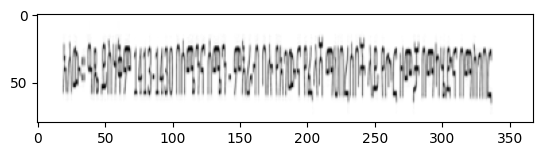

In [ ]:
import matplotlib.pyplot as plt
image = train_dataset.__getitem__(0)[0]
image = image.squeeze(0).numpy()


plt.imshow(image, cmap='gray')


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [34]:
import torch.nn as nn


class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = \
            channels[-1], img_height // 16 - 1, img_width // 4 - 1
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

In [35]:
from torch.nn import CTCLoss
from tqdm import tqdm

def evaluate(crnn, dataloader, criterion,
             max_iter=None, decode_method='beam_search', beam_size=10):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate")

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()

            tot_count += batch_size
            tot_loss += loss.item()
            target_length_counter = 0
            for pred, target_length in zip(preds, target_lengths):
                real = reals[target_length_counter:target_length_counter + target_length]
                target_length_counter += target_length
                if pred == real:
                    tot_correct += 1
                else:
                    wrong_cases.append((real, pred))

            pbar.update(1)
        pbar.close()

    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': tot_correct / tot_count,
        'wrong_cases': wrong_cases
    }
    return evaluation

In [37]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]

    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    return loss.item()

In [39]:
import torch.optim as optim
num_class = len(train_dataset.LABEL2CHAR) + 1
crnn = CRNN(1, img_height, img_width, num_class,
            map_to_seq_hidden=common_config['map_to_seq_hidden'],
            rnn_hidden=common_config['rnn_hidden'],
            leaky_relu=common_config['leaky_relu'])

crnn = crnn.to(device)
optimizer = optim.RMSprop(crnn.parameters(), lr=train_config['lr'], alpha=0.9, eps=1e-8)

criterion = CTCLoss(reduction='sum', zero_infinity=True)
criterion.to(device)
valid_interval = train_config['valid_interval']
save_interval = train_config['save_interval']
assert save_interval % valid_interval == 0
epochs = train_config['epochs']
show_interval = train_config['show_interval']
i = 1
for epoch in range(1, epochs + 1):
    print(f'epoch: {epoch}')
    tot_train_loss = 0.
    tot_train_count = 0
    for train_data in train_loader:
        loss = train_batch(crnn, train_data, optimizer, criterion, device)
        train_size = train_data[0].size(0)

        tot_train_loss += loss
        tot_train_count += train_size
        if i % show_interval == 0:
            print('train_batch_loss[', i, ']: ', loss / train_size)

        if i % valid_interval == 0:
            evaluation = evaluate(crnn, valid_loader, criterion,
                                    decode_method=evaluate_config['decode_method'],
                                    beam_size=evaluate_config['beam_size'])
            print('valid_evaluation: loss={loss}, acc={acc}'.format(**evaluation))

            if i % save_interval == 0:
                prefix = 'crnn'
                loss = evaluation['loss']
                save_model_path = os.path.join(common_config['checkpoints_dir'],
                                                f'{prefix}_{i:06}_loss{loss}.pt')
                torch.save(crnn.state_dict(), save_model_path)
                print('save model at ', save_model_path)

        i += 1

    print('train_loss: ', tot_train_loss / tot_train_count)

epoch: 1


train_batch_loss[ 10 ]:  62.30361557006836
train_batch_loss[ 20 ]:  63.52349853515625
train_batch_loss[ 30 ]:  26.852500915527344
train_batch_loss[ 40 ]:  35.930206298828125
train_batch_loss[ 50 ]:  22.765636444091797
train_batch_loss[ 60 ]:  48.71585464477539
train_batch_loss[ 70 ]:  56.77048110961914
train_batch_loss[ 80 ]:  36.006046295166016
train_batch_loss[ 90 ]:  29.411731719970703
train_batch_loss[ 100 ]:  53.040435791015625
train_batch_loss[ 110 ]:  80.82003784179688
train_batch_loss[ 120 ]:  40.25178527832031
train_batch_loss[ 130 ]:  52.83042526245117
train_batch_loss[ 140 ]:  46.528953552246094
train_batch_loss[ 150 ]:  25.86636734008789
train_batch_loss[ 160 ]:  9.788166046142578
train_batch_loss[ 170 ]:  42.89213562011719
train_batch_loss[ 180 ]:  20.308624267578125
train_batch_loss[ 190 ]:  51.577152252197266
train_batch_loss[ 200 ]:  66.7801284790039
train_batch_loss[ 210 ]:  19.709327697753906
train_batch_loss[ 220 ]:  49.85441207885742
train_batch_loss[ 230 ]:  30.687

Evaluate: 100%|██████████| 9/9 [05:30<00:00, 36.70s/it]


valid_evaluation: loss=44.30547023096008, acc=0.0
train_batch_loss[ 510 ]:  48.60564422607422
train_batch_loss[ 520 ]:  17.5671329498291
train_batch_loss[ 530 ]:  67.17079162597656
train_batch_loss[ 540 ]:  34.65511703491211
train_batch_loss[ 550 ]:  80.2613754272461
train_batch_loss[ 560 ]:  16.374454498291016
train_loss:  41.879414242433576
epoch: 2
train_batch_loss[ 570 ]:  23.455394744873047
train_batch_loss[ 580 ]:  104.23236846923828
train_batch_loss[ 590 ]:  31.79150390625
train_batch_loss[ 600 ]:  25.152822494506836
train_batch_loss[ 610 ]:  18.021636962890625
train_batch_loss[ 620 ]:  28.45266342163086
train_batch_loss[ 630 ]:  27.025287628173828
train_batch_loss[ 640 ]:  46.95989990234375
train_batch_loss[ 650 ]:  37.496551513671875
train_batch_loss[ 660 ]:  38.29051971435547
train_batch_loss[ 670 ]:  37.71225357055664
train_batch_loss[ 680 ]:  63.939697265625
train_batch_loss[ 690 ]:  53.43681716918945
train_batch_loss[ 700 ]:  33.47268295288086
train_batch_loss[ 710 ]:  50.

Evaluate: 100%|██████████| 9/9 [05:19<00:00, 35.46s/it]


valid_evaluation: loss=45.39518374358831, acc=0.0
train_batch_loss[ 1010 ]:  15.335004806518555
train_batch_loss[ 1020 ]:  51.0926399230957
train_batch_loss[ 1030 ]:  34.64600372314453
train_batch_loss[ 1040 ]:  54.72071838378906
train_batch_loss[ 1050 ]:  56.239105224609375
train_batch_loss[ 1060 ]:  62.34838104248047
train_batch_loss[ 1070 ]:  71.03438568115234
train_batch_loss[ 1080 ]:  27.797443389892578
train_batch_loss[ 1090 ]:  39.02399826049805
train_batch_loss[ 1100 ]:  25.274944305419922
train_batch_loss[ 1110 ]:  32.101051330566406
train_batch_loss[ 1120 ]:  45.29020309448242
train_loss:  39.771371127690465
epoch: 3
train_batch_loss[ 1130 ]:  46.605491638183594
train_batch_loss[ 1140 ]:  25.97997283935547
train_batch_loss[ 1150 ]:  70.29556274414062
train_batch_loss[ 1160 ]:  15.07337474822998
train_batch_loss[ 1170 ]:  20.518795013427734
train_batch_loss[ 1180 ]:  30.1117000579834
train_batch_loss[ 1190 ]:  17.538040161132812
train_batch_loss[ 1200 ]:  29.644935607910156
tr

Evaluate: 100%|██████████| 9/9 [05:23<00:00, 35.90s/it]


valid_evaluation: loss=52.849820194023195, acc=0.0
train_batch_loss[ 1510 ]:  72.8102798461914
train_batch_loss[ 1520 ]:  29.01522445678711
train_batch_loss[ 1530 ]:  33.761077880859375
train_batch_loss[ 1540 ]:  61.6980094909668
train_batch_loss[ 1550 ]:  28.51190948486328
train_batch_loss[ 1560 ]:  35.9026985168457
train_batch_loss[ 1570 ]:  32.42331314086914
train_batch_loss[ 1580 ]:  37.002079010009766
train_batch_loss[ 1590 ]:  12.430082321166992
train_batch_loss[ 1600 ]:  30.403535842895508
train_batch_loss[ 1610 ]:  48.04291534423828
train_batch_loss[ 1620 ]:  33.49858474731445
train_batch_loss[ 1630 ]:  18.630558013916016
train_batch_loss[ 1640 ]:  14.898149490356445
train_batch_loss[ 1650 ]:  7.878471374511719
train_batch_loss[ 1660 ]:  27.925865173339844
train_batch_loss[ 1670 ]:  24.77531623840332
train_batch_loss[ 1680 ]:  24.230688095092773
train_loss:  37.42471695329163
epoch: 4
train_batch_loss[ 1690 ]:  31.003250122070312
train_batch_loss[ 1700 ]:  13.504192352294922
tr

Evaluate: 100%|██████████| 9/9 [05:18<00:00, 35.33s/it]

valid_evaluation: loss=38.74520822298729, acc=0.0008920606601248885


KeyError: 'checkpoints_dir'